# Классификация Звездного Типа

## Описание данных
   - Temperature - температура звезды (K)
   - L - относительная светимость звезды, вычесляется по формуле L/Lo, где Lo = 3,828 * 10^26 Вт (Средняя светимость Солнца)
   - R - относительный радиус звезды, вычесляется по форсуле R/Ro, где Ro = 6,9551 * 10^8 м (Средний радиус Солнца) 
   - AM - Абсолютная величина звезды
   - Color - Общий цвет спектра
   - Spectral_Class - O,B,A,F,G,K,M / SMASS - https://en.wikipedia.org/wiki/Asteroid_spectral_types
   - Type - Красный Карлик, Коричневый Карлик, Белый Карлик, Главная последовательность , Супергиганты, Гипергиганты

## Задача
Классифицировать звезду (Type) от 0 до 5, где
   - Красный карлик - 0
   - Коричневый карлик - 1
   - Белый Карлик - 2
   - Главная последовательность - 3
   - Супер Гиганты - 4
   - Гипергиганты - 5

## Оглавление
1. [Загрузка данных](#1)
2. [Исследовательский анализ](#2)
3. [Подготовка данных к обучению](#3)
4. [Обучение моделей](#4)

<a id='1'>

## 1. Загрузка данных

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from IPython.display import SVG, display, HTML
from graphviz import Source

In [2]:
warnings.filterwarnings('ignore')
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [4]:
df = pd.read_csv('Stars.csv')

In [5]:
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [6]:
df.describe()

,Temperature,L,R,A_M,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


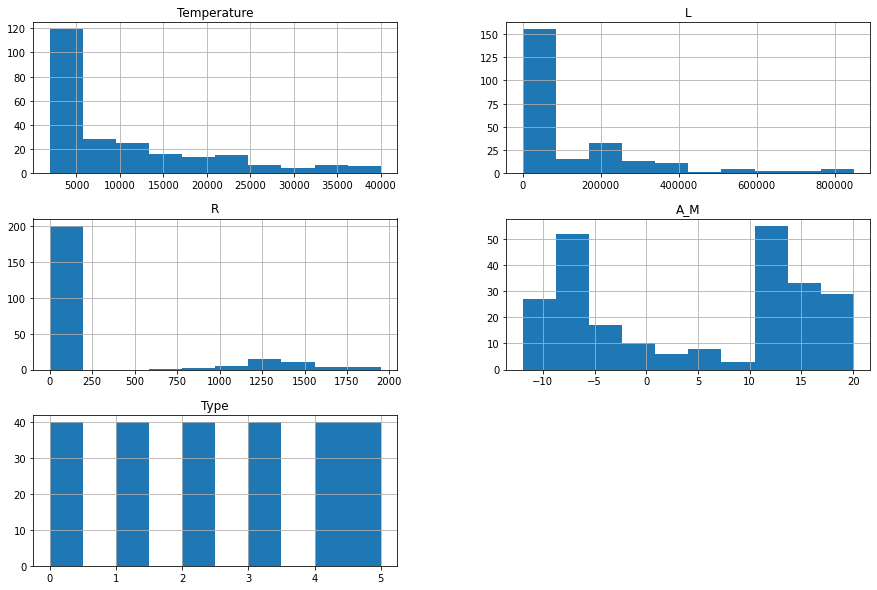

In [8]:
df.hist(figsize=(15, 10));

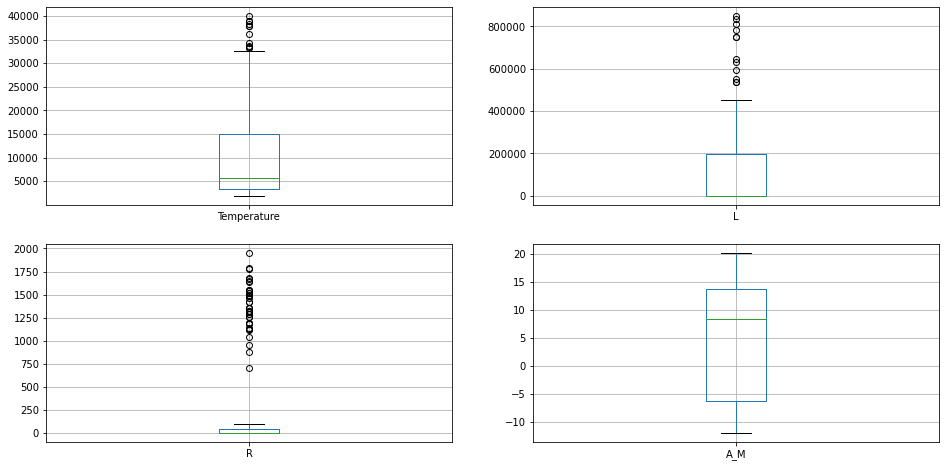

In [9]:
fig = plt.figure(figsize=(16,8))
subplot = 1
for col in df.select_dtypes(include='number').columns[:-1]:
        ax = fig.add_subplot(2, 2, subplot)
        df.boxplot(column=col)
        subplot += 1
plt.show()

In [10]:
df['Spectral_Class'].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64

In [11]:
df['Color'].value_counts()

Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
Orange                  2
yellowish               2
Whitish                 2
White-Yellow            1
Orange-Red              1
Pale yellow orange      1
Yellowish               1
Blue-White              1
Name: Color, dtype: int64

### Вывод
По просмотренным данным можно сделать следующие выводы:
   1. Даже не вооруженным взлядом видно, что распределения данных далеки от нормальности, и если осуществлять проверки гипотез, то это надо делать непараметрическими методами.
   2. Дисбаланс классов нет (что может не радовать:) )
   3. Дисбаланс есть в категориальных признаках, конечно рано говорить что нибудь по этому поводу, нужно провести исследовательский анализ, а там видно будет, что с этим можно сделать.
   4. Так же наблюдаются значения, которое отбиваются от среднего, но так как у нас класов более чем 2 то это может сыграть на руку


<a id='2'>
    
## 2. Исследовательский анализ

Так как у нас 6 классов, то посмотрим насколько различны эти классы между собой по признакам.

In [12]:
type_star = {0: 'Красный карлик', 
             1: 'Коричневый карлик', 
             2: 'Белый карлик', 
             3: 'Главная последовательность', 
             4: 'Супер Гиганты', 
             5: 'Гипергиганты'}

In [13]:
df['type_star'] = df['Type'].map(type_star)

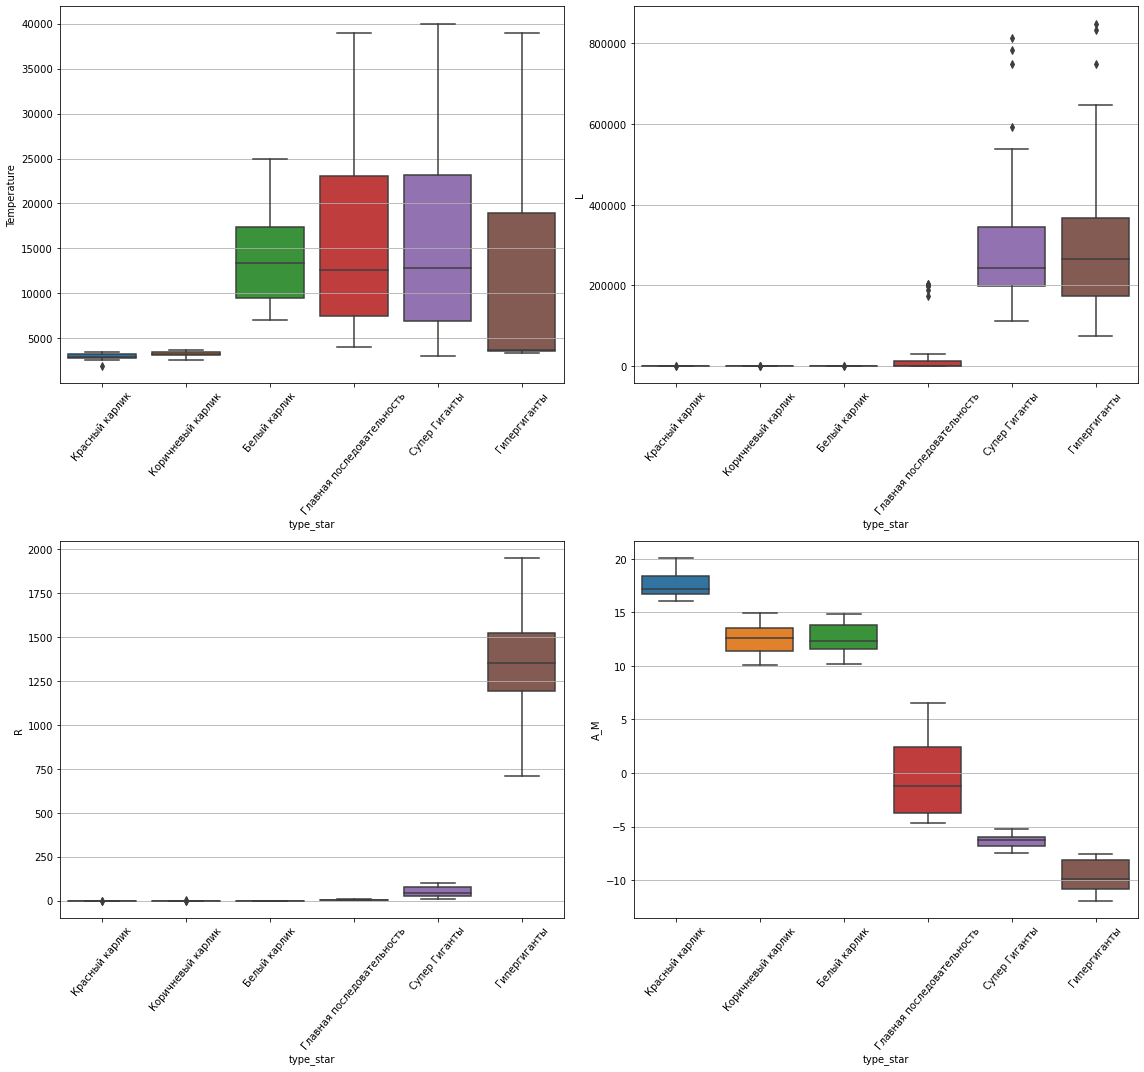

In [14]:
fig = plt.figure(figsize=(16,15))
subplot = 1
for col in df.select_dtypes(include='number').columns[:-1]:
        ax = fig.add_subplot(2, 2, subplot)
        sns.boxplot(x='type_star', y=col, data=df)
        plt.xticks(rotation=50)
        plt.grid(axis='y')
        subplot += 1
plt.tight_layout()
plt.show()

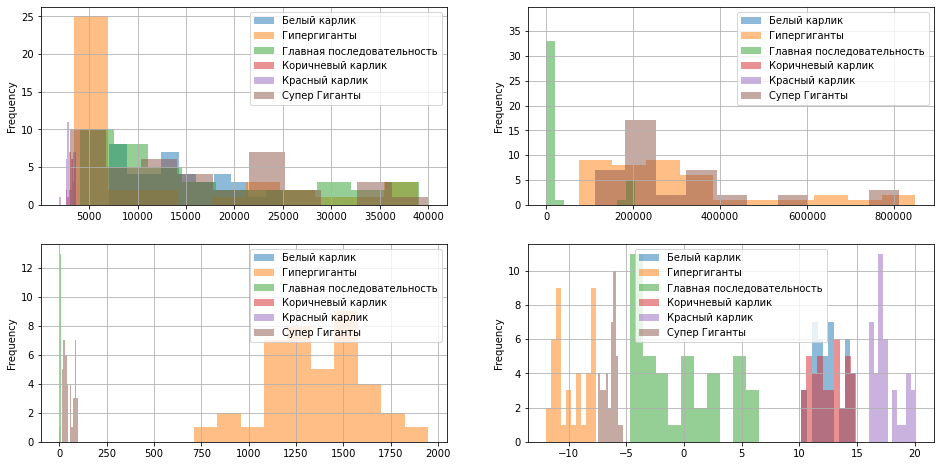

In [15]:
fig = plt.figure(figsize=(16,8))
subplot = 1
for col in df.select_dtypes(include='number').columns[:-1]:
        ax = fig.add_subplot(2, 2, subplot)
        df.groupby('type_star')[col].plot.hist(alpha=.5, grid=True, legend=True)
        subplot += 1
plt.show()

Различия есть, по признаку `A_M`- абсолютная величина 5 из 6 типов можно классифицировать практически без ошибочно, эта задача хорошо подойдет дереву решений. С остальными признаким немного посложнее, но они все равно могут внести свой вклад.

Теперь посмотрим детальнее на признаки с момощью матрицы корреляции...

In [16]:
color = {'Красный карлик': 'orange', 
         'Коричневый карлик': 'brown', 
         'Белый карлик': 'blue', 
         'Главная последовательность': 'yellow', 
         'Супер Гиганты': 'red', 
         'Гипергиганты': 'purple'}

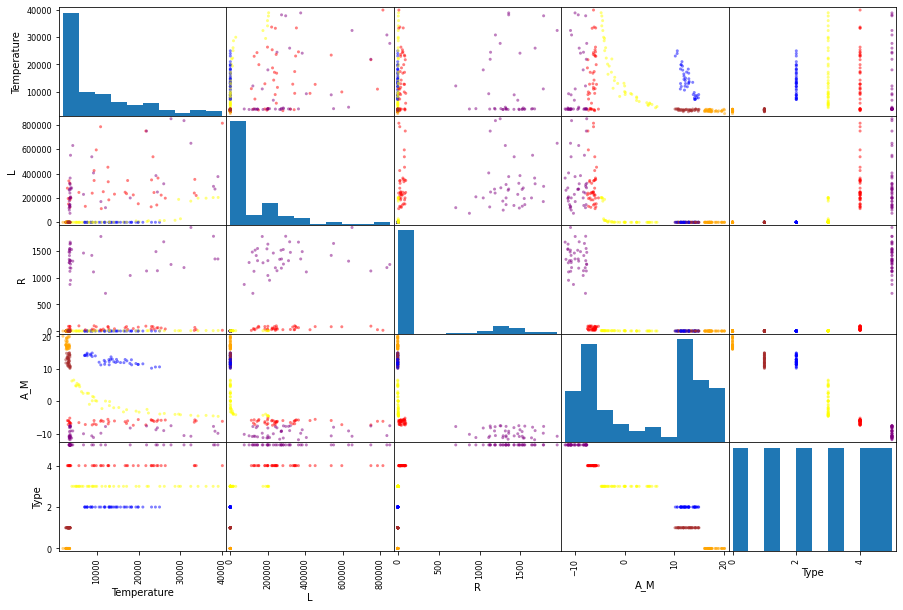

In [17]:
pd.plotting.scatter_matrix(df,
                           figsize=(15, 10),
                           c=df['type_star'].replace(color));

При детальном рассмотрение, можно сказать что гипергиганты в большинстве случаев создают отдельный кластер, их определить проблем не составит. По остальным типам конечно не такие различия как с гипергигантами, но также можно рассмотреть отдельные кластеры, например между `Temptrature` и `A_M`, а также между `R` и ` A_M` очень хорошо просматриваются закономерности, и можно разделить типы звезд между собой.

Последнее, на что можно посмотреть это матрица корреляций

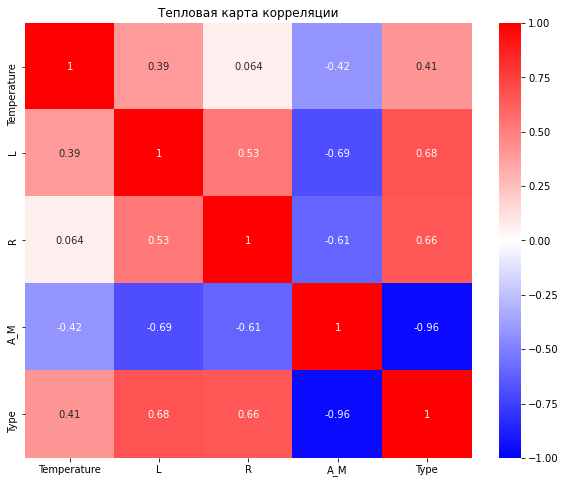

In [18]:
plt.figure(figsize=(10,8))
plt.title('Тепловая карта корреляции')
sns.heatmap(df.corr(), vmin=-1, cmap='bwr', annot=True);

Из графика мы еще раз убеждаемся в значимости признака `A_M` он имеет значительную отрицательную корреляцию с нашей целевой переменной, что дает нам право выдвинуть гипотезу о связи между ними. Остальные признаки имеют корреляциию между собой, но не достатучную чтоб утверждать о их взаимосвязи.

### Вывод
Из иследовательского анализа можно сделать следующие выводы:
   - Гиппергиганты очень хорошо отделены от остальных типов звезд, проблем в их классификации не будет
   - Признак абсолютное значение звезды (`A_M`) имеет очень весомый вклад в классификацию типов звезд
   - По данному анализу можно предположить дерьвья решений справятся с задачей на ура

<a id='3'>
    
## 3. Подготовка данных к обучению

Перебирать все модели смысла нет, попоробуем те которые по нашему предположению хорошо справятся с поставленной задачей. Так что для начала возьмом дерево решений и метод ближайших соседей. Но для начала подготовим данные к обучению. У нас есть категориальные признаки, закодируем их методом OneHotEncoding. Но для начала отберем все числовые признаки для дальнейшего маштабирования.

In [19]:
df = df.drop('type_star', axis=1)

In [20]:
df = pd.get_dummies(df, drop_first=True)

Отделим целевой признак...

In [21]:
X, y = df.drop('Type', axis=1), df['Type']

И разобьем данные на тренировочную и тестовую выборки

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [23]:
X_train.shape, X_test.shape

((180, 26), (60, 26))

In [24]:
X_train.head()

,Temperature,L,R,A_M,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,Color_Orange-Red,...,Color_Yellowish White,Color_white,Color_yellow-white,Color_yellowish,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
95,11250,672.00000,6.9800,-2.30,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
126,2935,0.00087,0.0932,16.88,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
120,3323,0.00043,0.0912,17.16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
67,2817,0.00098,0.0911,16.45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101,40000,813000.00000,14.0000,-6.23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<a id='4'>

## 4. Обучение модели

In [25]:
def fit_model(model, params):
    grid_model = GridSearchCV(model, scoring='accuracy', cv=5, param_grid=params)
    grid_model.fit(X_train, y_train)
    print(grid_model.best_params_)
    print(classification_report(y_test, grid_model.predict(X_test)))
    return grid_model.best_estimator_

<a id='4.1'>
    
### 4.1 DecisionTreeClassifier

In [26]:
params = {'max_depth': [3, 5, 8],
          'max_leaf_nodes': [None, 5, 9],
          'min_samples_leaf': [None, 10, 20]}

In [27]:
dtc = fit_model(tree.DecisionTreeClassifier(random_state=42), params)

{'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Как и предполагалось дерево решений справилось на ура. Посмотрим как модель смогла классифицировать тип звезды...

In [28]:
graph = Source(tree.export_graphviz(dtc, out_file=None,
                                    feature_names=list(X_train),
                                    class_names = ['Красный карлик', 'Коричневый карлик', 
                                                   'Белый карлик', 'Главная последовательность', 
                                                   'Супер Гиганты', 'Гипергиганты'],
                                    filled=True))

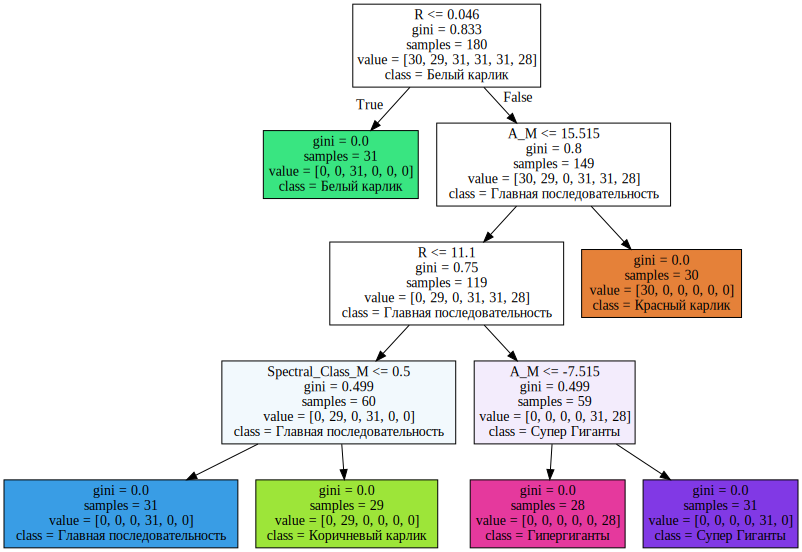

In [29]:
display(SVG(graph.pipe(format='svg')))

In [30]:
fearure = pd.DataFrame({'feature_importances': dtc.feature_importances_}, index=X_train.columns)

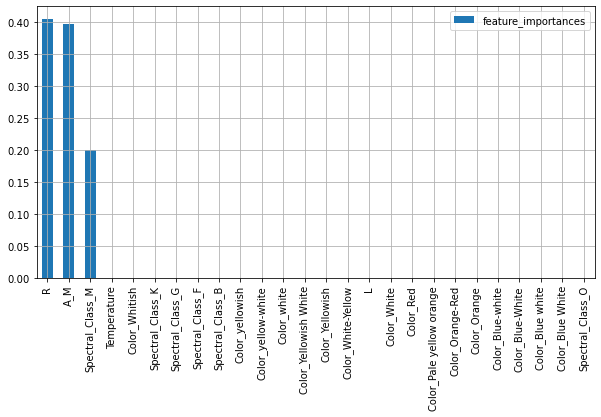

In [31]:
fearure.sort_values(by='feature_importances', ascending=False).plot(kind='bar', figsize=(10,5), grid=True);

## Вывод
Нам потребовалась всего одна модель, которая прекрасно классифицирует тип звезды. Причем она это делает всего по трем признакам, остальные не успела задействовать). По моему мнение дерево решений отлично подходит на роль классификатора, так как его действия очень хорошо интерпретируются. По диаграмме выше все детально указано. Поэтому остальные модели я не рассмотривал, хотя думаю что с моделями, где вычисляется расстоние между объектами такими как метод ближайших соседей или kmeans, тоже не было проблем. Как я указал выше комметарии к матрице корреляций, признаки очень хорошо разделяются по типам звезд, и кластеризуются в одном месте.